## Урок 9. Использование на практике методов снижения размерности
Использование алгоритмов понижения размерности для улучшения классификации новостей (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html)    

Цель задания: Исследовать влияние различных методов понижения размерности на качество классификации текстовых данных.    

Датасет: Набор данных новостных статей    
(датасет '20 Newsgroups' доступный в sklearn.datasets).    

Задачи:    

1. Загрузите датасет '20 Newsgroups' из sklearn.

2. Проведите предобработку данных (очистка текста, удаление стоп-слов, векторизация с использованием TF-IDF).

3. Примените к полученным векторам TF-IDF следующие методы понижения размерности:
— PCA (Principal Component Analysis)
— t-SNE (t-distributed Stochastic Neighbor Embedding)
— UMAP (Uniform Manifold Approximation and Projection).

4. После понижения размерности данных используйте любой метод машинного обучения для классификации новостей по темам.

5. Сравните качество классификации для каждого метода понижения размерности. Используйте метрики точности и F1-меру.

6. Визуализируйте двумерное представление данных для каждого метода понижения размерности, чтобы оценить, как алгоритмы справляются с сепарацией классов.

7. Напишите отчёт, в котором обсудите, какой метод понижения размерности оказал наиболее значительное влияние на качество классификации и почему.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score


c:\Users\Spiro\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Загрузка данных

In [2]:
newsgroups_data = fetch_20newsgroups(subset='all')
data = {
    'text': newsgroups_data.data,
    'target': newsgroups_data.target}
df = pd.DataFrame(data)
df['category'] = df['target'].apply(lambda x: newsgroups_data.target_names[x])
df


,text,target,category
0,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...,10,rec.sport.hockey
1,From: mblawson@midway.ecn.uoknor.edu (Matthew ...,3,comp.sys.ibm.pc.hardware
2,From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject...,17,talk.politics.mideast
3,From: guyd@austin.ibm.com (Guy Dawson)\nSubjec...,3,comp.sys.ibm.pc.hardware
4,From: Alexander Samuel McDiarmid <am2o+@andrew...,4,comp.sys.mac.hardware
...,...,...,...
18841,From: jim.zisfein@factory.com (Jim Zisfein) \n...,13,sci.med
18842,From: rdell@cbnewsf.cb.att.com (richard.b.dell...,12,sci.electronics
18843,From: westes@netcom.com (Will Estes)\nSubject:...,3,comp.sys.ibm.pc.hardware
18844,From: steve@hcrlgw (Steven Collins)\nSubject: ...,1,comp.graphics


In [3]:
print("Размер датасета:", df.shape)
print("Пропущенные значения:")
print(df.isnull().sum())

Размер датасета: (18846, 3)
Пропущенные значения:
text        0
target      0
category    0
dtype: int64


## EDA

In [4]:
df.describe().T.style.background_gradient(cmap='YlOrRd')

,count,mean,std,min,25%,50%,75%,max
target,18846.000000,9.293166,5.562798,0.000000,5.000000,9.000000,14.000000,19.000000


In [5]:
df['text'].apply(len).describe()

count     18846.000000
mean       1902.525894
std        3984.970264
min         115.000000
25%         751.000000
50%        1175.000000
75%        1874.750000
max      160616.000000
Name: text, dtype: float64

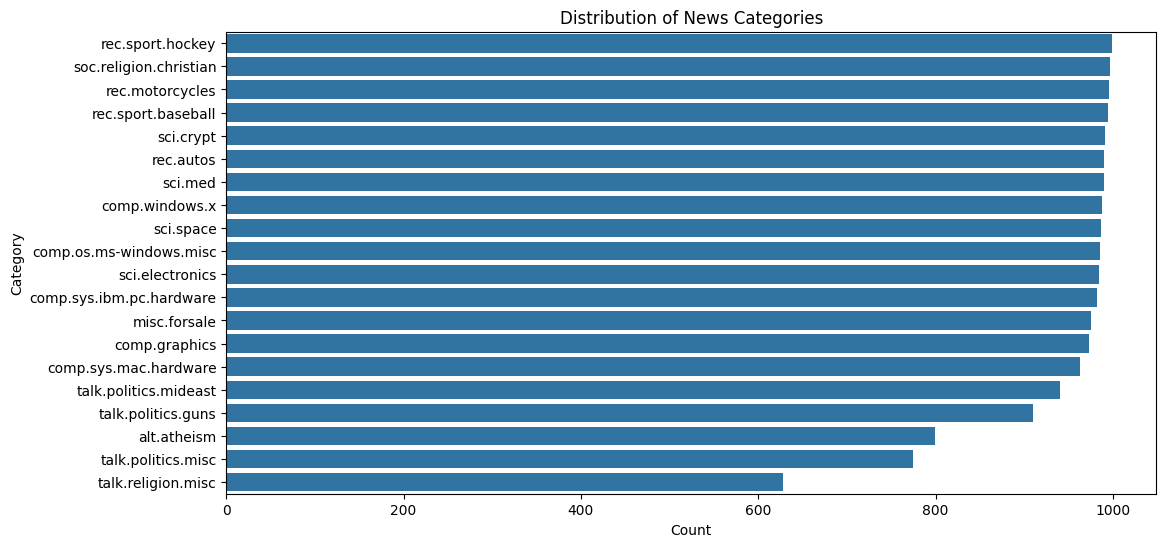

In [6]:
# Распределение классов
plt.figure(figsize=(12, 6))
sns.countplot(y='category', data=df, order=df['category'].value_counts().index)
plt.title('Distribution of News Categories')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()

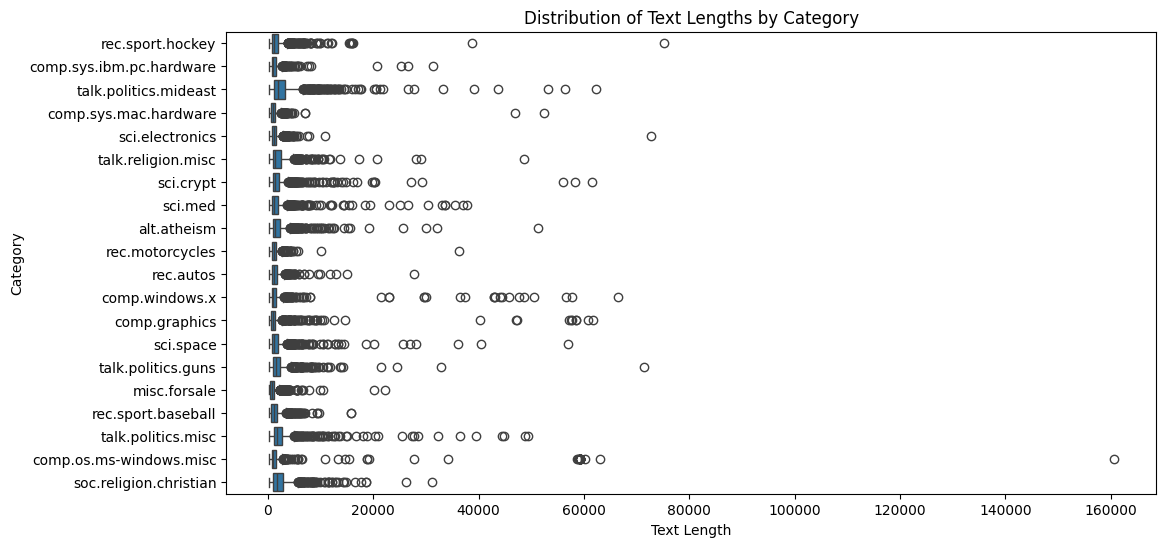

In [7]:
# Длина текстов в различных категориях
df['text_length'] = df['text'].apply(len)

plt.figure(figsize=(12, 6))
sns.boxplot(y='category', x='text_length', data=df, orient='h')
plt.title('Distribution of Text Lengths by Category')
plt.xlabel('Text Length')
plt.ylabel('Category')
plt.show()

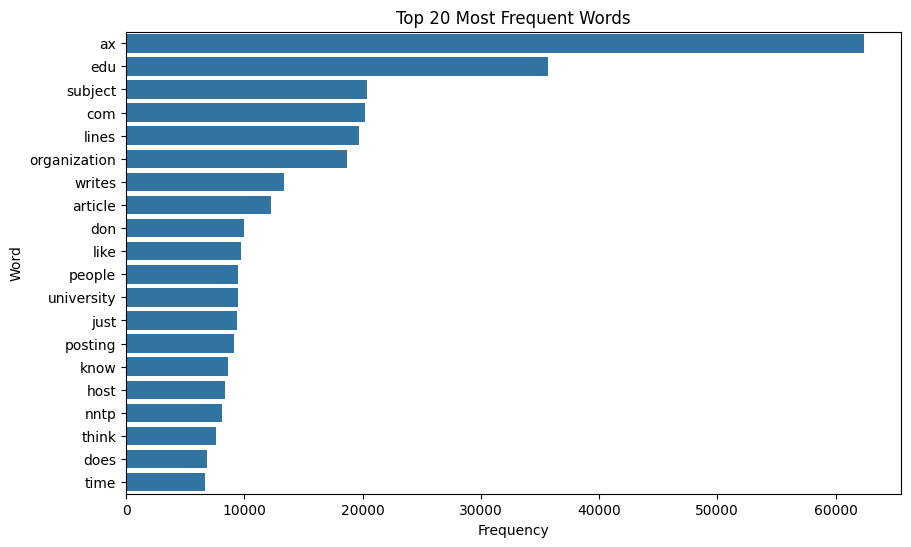

In [8]:
# Частотный анализ слов
vectorizer = CountVectorizer(stop_words='english', max_features=20)
X = vectorizer.fit_transform(df['text'])

# X.toarray(): Преобразует разреженную матрицу в плотный массив (numpy array), чтобы можно было легко суммировать частоты.
# sum(axis=0): Суммирует частоты слов по всем документам, создавая вектор частот,
# где каждая позиция соответствует суммарной частоте одного слова во всех документах.
word_freq = pd.DataFrame({
    'word': vectorizer.get_feature_names_out(),
    'frequency': X.toarray().sum(axis=0)
})

plt.figure(figsize=(10, 6))
sns.barplot(x='frequency', y='word', data=word_freq.sort_values(by='frequency', ascending=False))
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()


## Предобработка данных

In [9]:
# remove=('headers', 'footers', 'quotes') - из текстов будут удалены заголовки, подписи и цитаты.
newsgroups_data = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

# Удаление стоп-слов
def remove_stopwords(text):
    words = text.split()
    words = [word for word in words if word.lower() not in ENGLISH_STOP_WORDS]
    return ' '.join(words)
cleaned_texts = [remove_stopwords(text) for text in newsgroups_data.data]

# Преобразование очищенного текста в TF-IDF признаки (будут выбраны только 5к наиболее значимых токенов)
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5_000)
tfidf_features = tfidf_vectorizer.fit_transform(cleaned_texts)

# Преобразуем числовые метки категорий в строковые названия категорий
category_labels = [newsgroups_data.target_names[i] for i in newsgroups_data.target]

## Приминение методов понижения размерности

### PCA 

In [10]:
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(tfidf_features.toarray())


In [ ]:
# Сколько информации сохранено в первых двух компонентах PCA
explained_variance = pca.explained_variance_ratio_
total_explained_variance = explained_variance.sum()
print(f'PCA - Total Explained Variance (information retained): {total_explained_variance:.2f}')

PCA - Total Explained Variance (information retained): 0.01


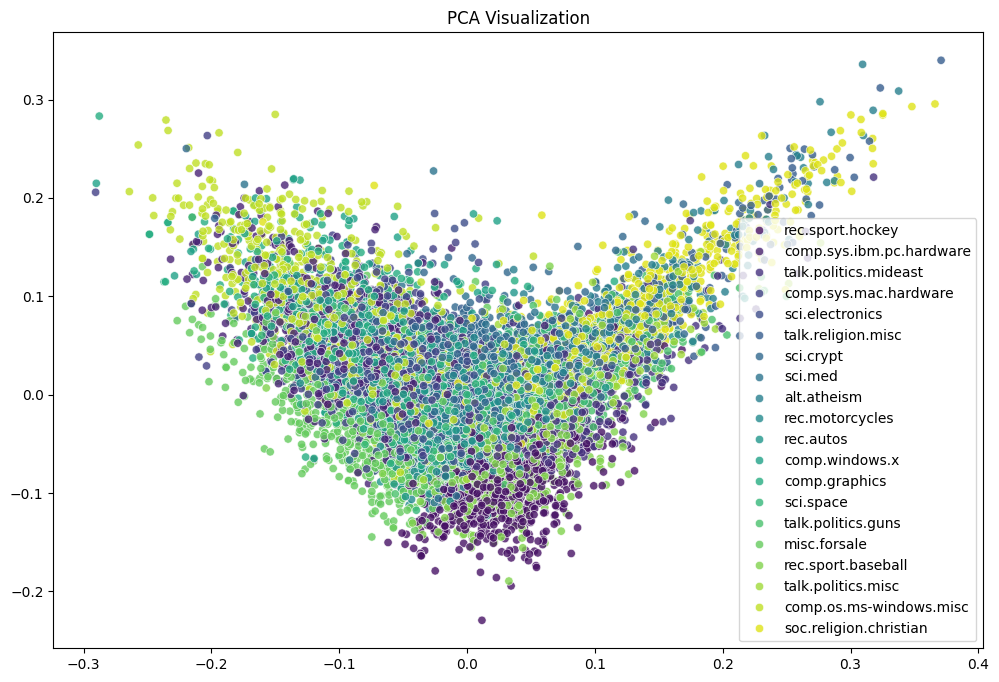

In [11]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=category_labels, palette='viridis', legend='full', alpha=0.8)
plt.title('PCA Visualization')
plt.show()

### t-SNE 

In [12]:
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(tfidf_features.toarray())


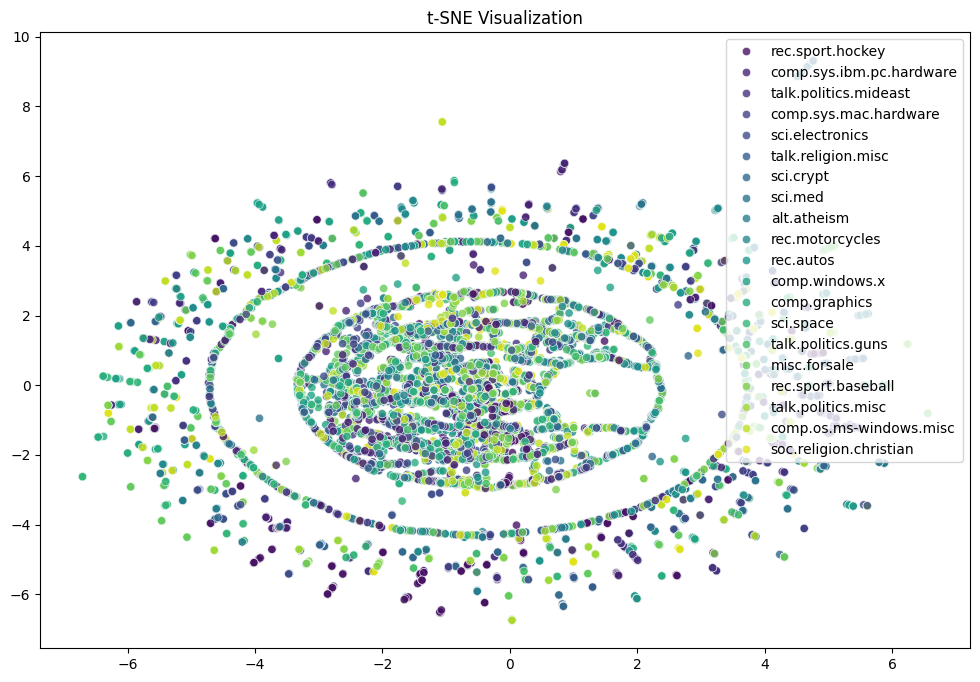

In [13]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=category_labels, palette='viridis', legend='full', alpha=0.8)
plt.title('t-SNE Visualization')
plt.show()

### UMAP  

In [14]:
umap = UMAP(n_components=2, random_state=42)
umap_result = umap.fit_transform(tfidf_features.toarray())


c:\Users\Spiro\AppData\Local\Programs\Python\Python38\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


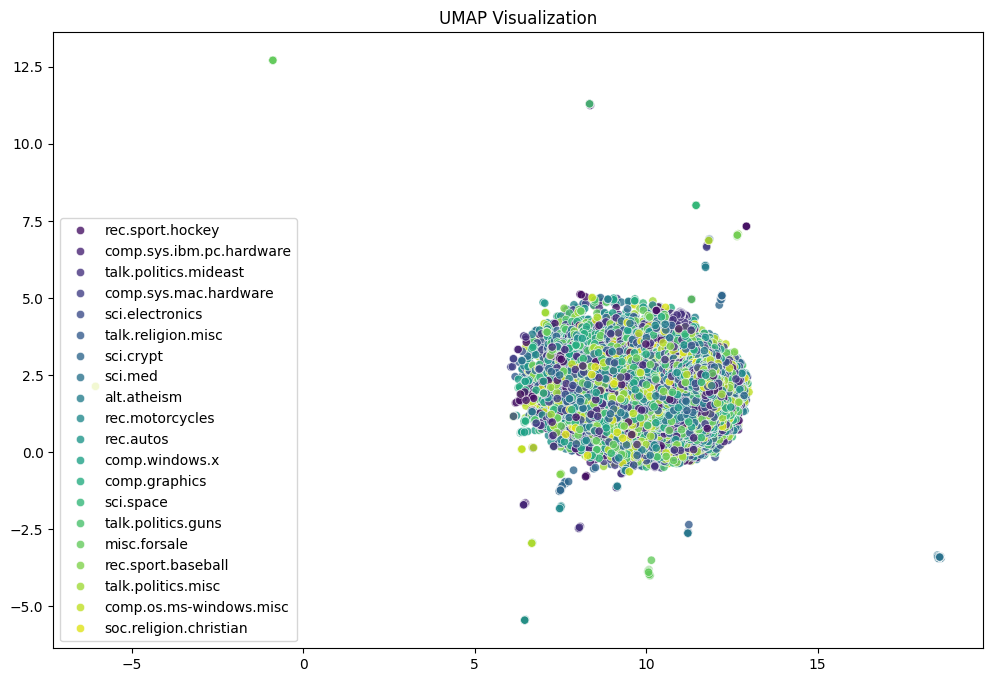

In [15]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x=umap_result[:, 0], y=umap_result[:, 1], hue=category_labels, palette='viridis', legend='full', alpha=0.8)
plt.title('UMAP Visualization')
plt.show()


## Разделение данных на тренировочную и тестовую выборки

In [17]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, newsgroups_data.target, test_size=0.2, random_state=42)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(pca_result, newsgroups_data.target, test_size=0.2, random_state=42)
X_train_tsne, X_test_tsne, y_train_tsne, y_test_tsne = train_test_split(tsne_result, newsgroups_data.target, test_size=0.2, random_state=42)
X_train_umap, X_test_umap, y_train_umap, y_test_umap = train_test_split(umap_result, newsgroups_data.target, test_size=0.2, random_state=42)

# Получение размеров данных
def get_shape(X):
    if hasattr(X, 'shape'):
        return X.shape[0]  # Размер первой размерности (количество примеров)
    else:
        return len(X)  # Для плотных матриц

print(f"Размер X_train: {get_shape(X_train)}")
print(f"Размер X_test: {get_shape(X_test)}")
print(f"Размер y_train: {len(y_train)}")
print(f"Размер y_test: {len(y_test)}")

print(f"Размер X_train_pca: {get_shape(X_train_pca)}")
print(f"Размер X_test_pca: {get_shape(X_test_pca)}")
print(f"Размер y_train_pca: {len(y_train_pca)}")
print(f"Размер y_test_pca: {len(y_test_pca)}")

print(f"Размер X_train_tsne: {get_shape(X_train_tsne)}")
print(f"Размер X_test_tsne: {get_shape(X_test_tsne)}")
print(f"Размер y_train_tsne: {len(y_train_tsne)}")
print(f"Размер y_test_tsne: {len(y_test_tsne)}")

print(f"Размер X_train_umap: {get_shape(X_train_umap)}")
print(f"Размер X_test_umap: {get_shape(X_test_umap)}")
print(f"Размер y_train_umap: {len(y_train_umap)}")
print(f"Размер y_test_umap: {len(y_test_umap)}")


Размер X_train: 15076
Размер X_test: 3770
Размер y_train: 15076
Размер y_test: 3770
Размер X_train_pca: 15076
Размер X_test_pca: 3770
Размер y_train_pca: 15076
Размер y_test_pca: 3770
Размер X_train_tsne: 15076
Размер X_test_tsne: 3770
Размер y_train_tsne: 15076
Размер y_test_tsne: 3770
Размер X_train_umap: 15076
Размер X_test_umap: 3770
Размер y_train_umap: 15076
Размер y_test_umap: 3770


## Обучение моделей логистической регрессии

In [18]:
# Функция для обучения модели и оценки метрик
def evaluate_model(X_train, X_test, y_train, y_test):
    classifier = LogisticRegression(max_iter=1000, random_state=42)

    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    #average='weighted' - взвешенное среднее
    f1 = f1_score(y_test, y_pred, average='weighted')

    return accuracy, f1


In [19]:
accuracy, f1 = evaluate_model(X_train, X_test, y_train, y_test)
accuracy_pca, f1_pca = evaluate_model(X_train_pca, X_test_pca, y_train_pca, y_test_pca)
accuracy_tsne, f1_tsne = evaluate_model(X_train_tsne, X_test_tsne, y_train_tsne, y_test_tsne)
accuracy_umap, f1_umap = evaluate_model(X_train_umap, X_test_umap, y_train_umap, y_test_umap)

print(f'Без понижения размерности - Accuracy: {accuracy:.2f}, F1-score: {f1:.2f}')
print(f'PCA - Accuracy: {accuracy_pca:.2f}, F1-score: {f1_pca:.2f}')
print(f't-SNE - Accuracy: {accuracy_tsne:.2f}, F1-score: {f1_tsne:.2f}')
print(f'UMAP - Accuracy: {accuracy_umap:.2f}, F1-score: {f1_umap:.2f}')

Без понижения размерности - Accuracy: 0.69, F1-score: 0.69
PCA - Accuracy: 0.21, F1-score: 0.13
t-SNE - Accuracy: 0.08, F1-score: 0.04
UMAP - Accuracy: 0.06, F1-score: 0.03


Учитывая, что модели понижения размерности выделяли только 2 главные компоненты, а не большее количество, результаты обучения моделей на выделенных главнных компонентах ожидаемо хуже качества предсказания модели на данных, без выделения главных компонент.

Наибольшее информации выделили главные компоненты PCA.

Наиболее интересные для анализа графики, получились у t-SNE и PCA.